# **Pendahuluan**

# Exploratory Data Analysis (EDA)
## Capstone Project – Machine Learning 1

Notebook ini bertujuan untuk melakukan eksplorasi awal terhadap dataset aktivitas belajar pengguna pada **Use Case DC-08 AI Learning Insight**.  
Analisis ini digunakan untuk memahami pola belajar siswa dan menentukan fitur yang relevan untuk model pembelajaran mesin.

Tahapan utama:
1. Memuat dan menggabungkan seluruh dataset.
2. Melakukan pembersihan dan pemeriksaan awal data.
3. Melakukan feature engineering untuk menghasilkan metrik pembelajaran.
4. Menampilkan visualisasi EDA dan insight awal.


# **Load Dataset**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Muat semua dataset
users = pd.read_excel('/content/users.xlsx')
journeys = pd.read_excel('/content/developer_journeys.xlsx')
tutorials = pd.read_excel('/content/developer_journey_tutorials.xlsx')
trackings = pd.read_excel('/content/developer_journey_trackings.xlsx')
submissions = pd.read_excel('/content/developer_journey_submissions.xlsx')
completions = pd.read_excel('/content/developer_journey_completions.xlsx')
exam_registrations = pd.read_excel('/content/exam_registrations.xlsx')
exam_results = pd.read_excel('/content/exam_results.xlsx')

# Tampilkan ringkasan awal
print("Jumlah baris per dataset:")
for name, df in {
    'users': users,
    'journeys': journeys,
    'tutorials': tutorials,
    'trackings': trackings,
    'submissions': submissions,
    'completions': completions,
    'exam_registrations': exam_registrations,
    'exam_results': exam_results
}.items():
    print(f"{name}: {len(df)}")


Jumlah baris per dataset:
users: 22
journeys: 74
tutorials: 2203
trackings: 6641
submissions: 123
completions: 58
exam_registrations: 679
exam_results: 679


# **Gabungkan Dataset**

In [ ]:
# Rename agar kolom ID unik
users = users.rename(columns={'id': 'user_id'})
tutorials = tutorials.rename(columns={'id': 'tutorial_ref_id'})
submissions = submissions.rename(columns={'id': 'submission_id'})
completions = completions.rename(columns={'id': 'completion_id'})
exam_registrations = exam_registrations.rename(columns={'id': 'exam_reg_id'})
exam_results = exam_results.rename(columns={'id': 'exam_result_id'})

# Gabungkan exam_registrations dan exam_results
exam_data = pd.merge(exam_registrations, exam_results, left_on='exam_reg_id', right_on='exam_registration_id', how='left')

# Gabungkan dengan tutorials
exam_data = pd.merge(exam_data, tutorials, left_on='tutorial_id', right_on='tutorial_ref_id', how='left')

# Gabungkan trackings dengan tutorials
tracking_data = pd.merge(trackings, tutorials, left_on='tutorial_id', right_on='tutorial_ref_id', how='left')

# Gabungkan semua aktivitas per user
merged = pd.merge(users, tracking_data, left_on='user_id', right_on='developer_id', how='left')

# Gabungkan submissions dan completions
merged = pd.merge(merged, submissions, left_on=['user_id', 'journey_id'],
                  right_on=['submitter_id', 'journey_id'], how='left', suffixes=('', '_sub') )
merged = pd.merge(merged, completions, left_on=['user_id', 'journey_id'],
                  right_on=['user_id', 'journey_id'], how='left', suffixes=('', '_comp'))

# Gabungkan dengan exam_data
merged = pd.merge(merged, exam_data, left_on=['user_id', 'tutorial_id'],
                  right_on=['examinees_id', 'tutorial_id'], how='left', suffixes=('', '_exam'))

print("Data gabungan akhir:", merged.shape)
display(merged.head())


Data gabungan akhir: (16111, 105)


,user_id,display_name,name,email,phone,user_role,user_verification_status,created_at_x,updated_at_x,deleted_at,...,content_exam,requirements_exam,submit_only_requirements_exam,position_exam,status_y_exam,created_at_exam,updated_at_y_exam,trial_exam,author_id_exam,is_main_module_exam
0,96989.0,igihcksn,Inggih Wicaksono,igihcksn@gmail.com,6.281271e+12,2.0,1.0,2017-04-03 19:16:35,2025-04-28 11:54:11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
1,96989.0,igihcksn,Inggih Wicaksono,igihcksn@gmail.com,6.281271e+12,2.0,1.0,2017-04-03 19:16:35,2025-04-28 11:54:11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
2,96989.0,igihcksn,Inggih Wicaksono,igihcksn@gmail.com,6.281271e+12,2.0,1.0,2017-04-03 19:16:35,2025-04-28 11:54:11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
3,96989.0,igihcksn,Inggih Wicaksono,igihcksn@gmail.com,6.281271e+12,2.0,1.0,2017-04-03 19:16:35,2025-04-28 11:54:11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN
4,96989.0,igihcksn,Inggih Wicaksono,igihcksn@gmail.com,6.281271e+12,2.0,1.0,2017-04-03 19:16:35,2025-04-28 11:54:11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN


# **Feature Engineering**

In [ ]:
# Konversi kolom waktu
for col in ['created_at_x', 'created_at_y', 'first_opened_at', 'last_viewed']:
    if col in merged.columns:
        merged[col] = pd.to_datetime(merged[col], errors='coerce')

# Learning speed (jam)
if 'created_at_x' in merged.columns and 'created_at_y' in merged.columns:
    merged['learning_speed'] = (merged['created_at_y'] - merged['created_at_x']).dt.total_seconds() / 3600
else:
    merged['learning_speed'] = np.nan

# Hubungkan exam_results dengan user
exam_results_user = pd.merge(exam_results,
    exam_registrations, left_on='exam_registration_id', right_on='exam_reg_id', how='left').rename(columns={'examinees_id': 'user_id'})

# Consistency score (stabilitas hasil exam per user)
consistency = exam_results_user.groupby('user_id')['score'].std().reset_index()
consistency.rename(columns={'score': 'consistency_score'}, inplace=True)
merged = pd.merge(merged, consistency, on='user_id', how='left')

# Persistence score (jumlah ujian per user)
persistence = exam_registrations.groupby('examinees_id')['exam_reg_id'].count().reset_index()
persistence.rename(columns={'examinees_id': 'user_id', 'exam_reg_id': 'persistence_score'}, inplace=True)
merged = pd.merge(merged, persistence, on='user_id', how='left')

if 'developer_id' in trackings.columns:
    activity = trackings.groupby('developer_id')['tutorial_id'].count().reset_index()
    activity.rename(columns={'developer_id': 'user_id', 'tutorial_id': 'activity_score'}, inplace=True)
    merged = pd.merge(merged, activity, on='user_id', how='left')
else:
    merged['activity_score'] = np.nan

if 'user_id' in completions.columns:
    completion = completions.groupby('user_id')['journey_id'].count().reset_index()
    completion.rename(columns={'journey_id': 'completion_score'}, inplace=True)
    merged = pd.merge(merged, completion, on='user_id', how='left')
else:
    merged['completion_score'] = np.nan

learning_data = merged[['user_id', 'learning_speed', 'consistency_score', 'persistence_score', 'activity_score', 'completion_score']].drop_duplicates()

# Hapus data kosong
learning_data = learning_data.dropna(subset=['learning_speed', 'consistency_score', 'persistence_score', 'activity_score', 'completion_score'])

print("\n Dataset akhir:")
display(learning_data.describe())


 Dataset akhir:


,user_id,learning_speed,consistency_score,persistence_score,activity_score,completion_score
count,4.234000e+03,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000
mean,1.226305e+06,8566.632775,22.678581,218.393009,2294.799244,19.924185
std,1.589600e+06,27096.595563,3.547239,91.465719,750.735879,6.744794
min,9.698900e+04,-54102.631389,10.954451,5.000000,38.000000,1.000000
25%,9.698900e+04,-8237.013819,22.519134,178.000000,2205.000000,19.000000
50%,9.382760e+05,8517.322361,22.519134,178.000000,2205.000000,19.000000
75%,9.382760e+05,28554.547361,25.974696,336.000000,3069.000000,27.000000
max,5.410562e+06,73674.884722,26.075938,336.000000,3069.000000,27.000000


In [ ]:
learning_data.to_csv("learning_features.csv", index=False)

# **Exploratory Data Analysis (EDA)**

Statistik Deskriptif Fitur Pembelajaran:



,user_id,learning_speed,consistency_score,persistence_score,activity_score,completion_score
count,4.234000e+03,4234.000000,4234.000000,4234.000000,4234.000000,4234.000000
mean,1.226305e+06,8566.632775,22.678581,218.393009,2294.799244,19.924185
std,1.589600e+06,27096.595563,3.547239,91.465719,750.735879,6.744794
min,9.698900e+04,-54102.631389,10.954451,5.000000,38.000000,1.000000
25%,9.698900e+04,-8237.013819,22.519134,178.000000,2205.000000,19.000000
50%,9.382760e+05,8517.322361,22.519134,178.000000,2205.000000,19.000000
75%,9.382760e+05,28554.547361,25.974696,336.000000,3069.000000,27.000000
max,5.410562e+06,73674.884722,26.075938,336.000000,3069.000000,27.000000



--------------------------------------------------------

Korelasi antar Fitur:



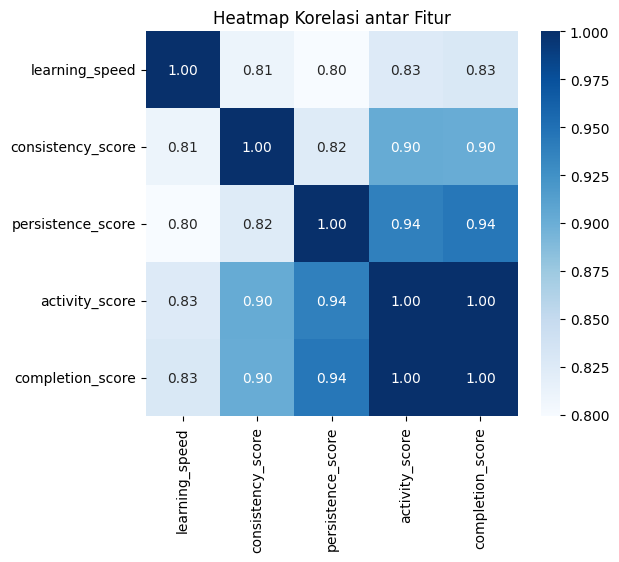

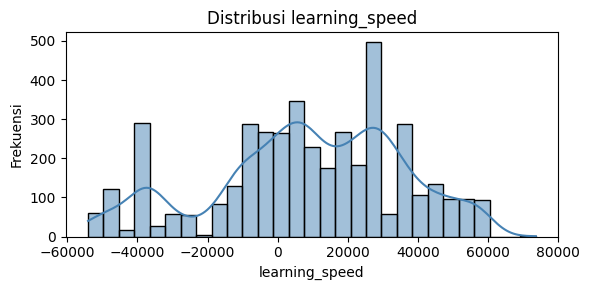

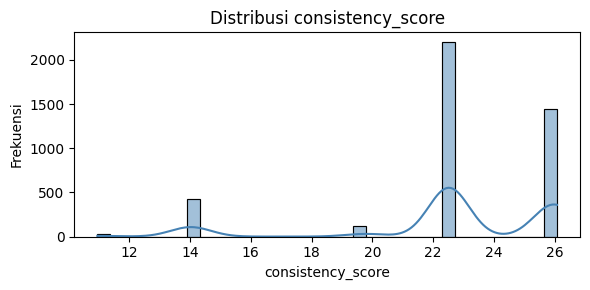

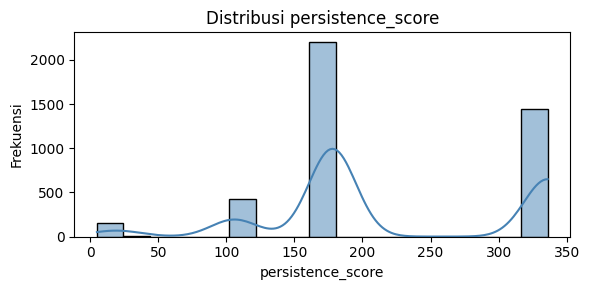

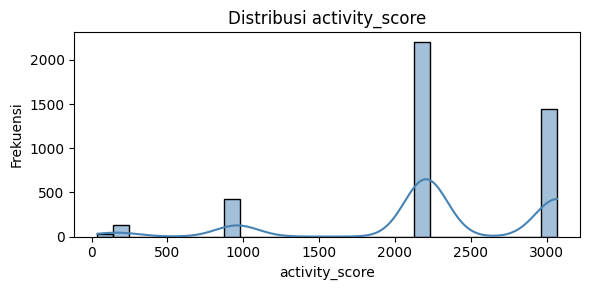

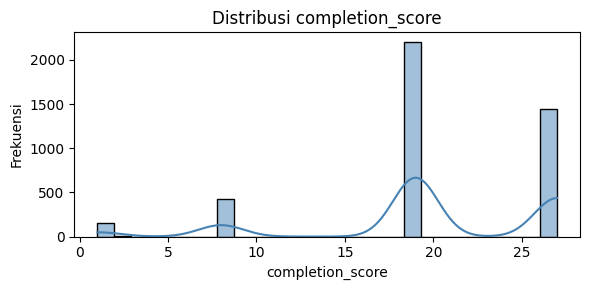



Hubungan Antar Fitur (Pairplot):



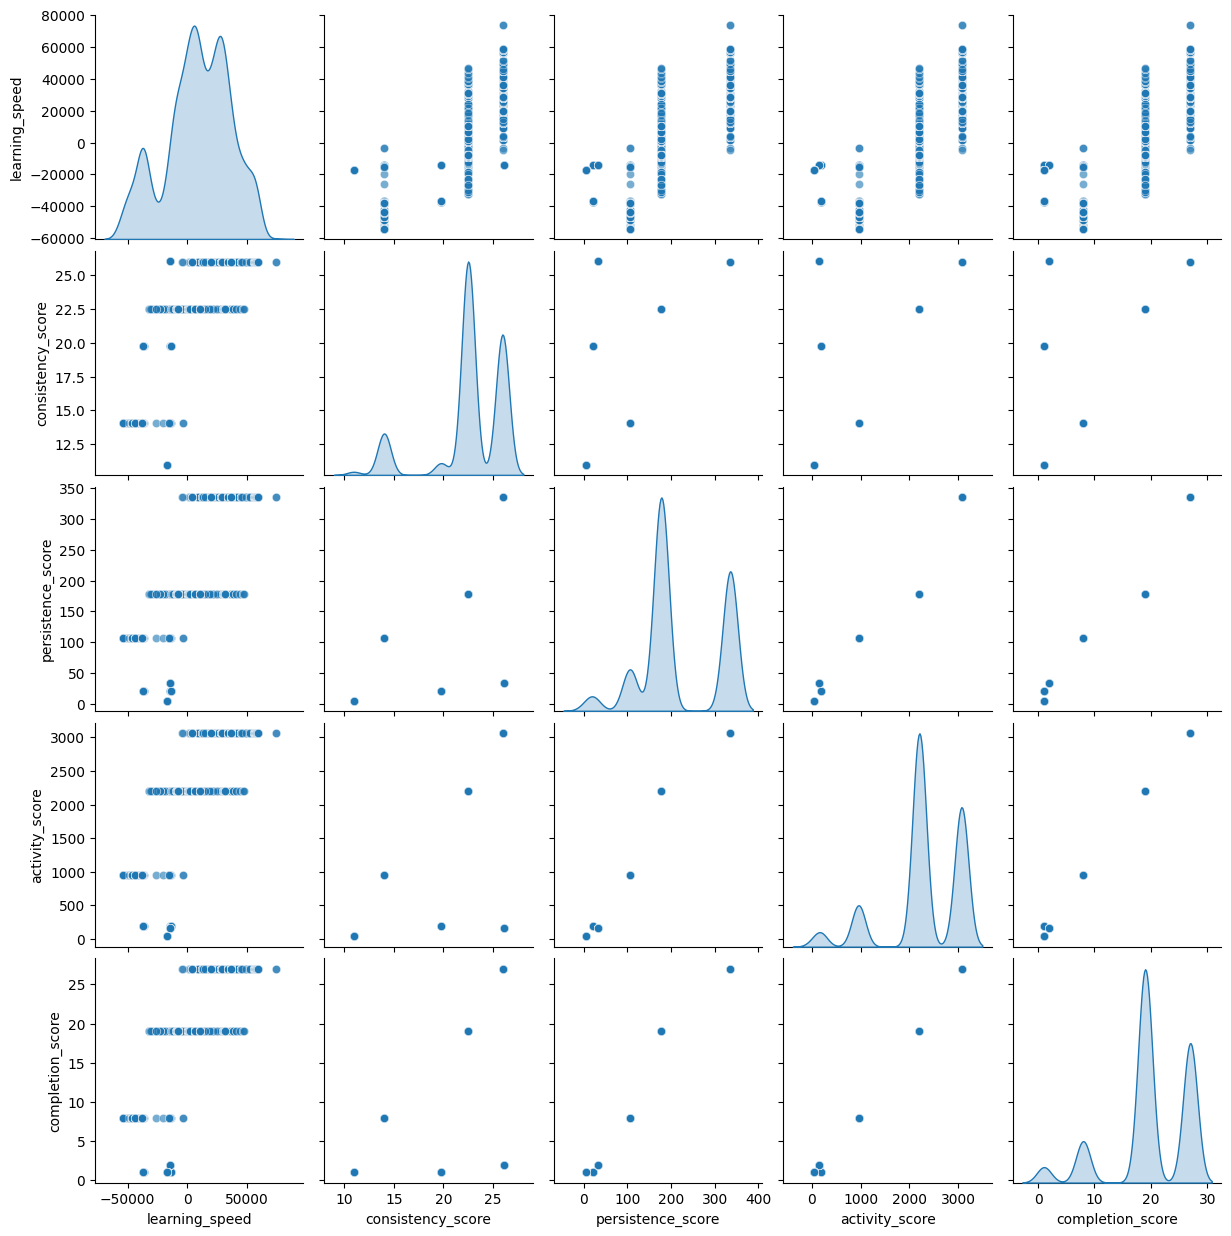



Visualisasi Profil Rata-Rata 5 Fitur (Radar Chart):



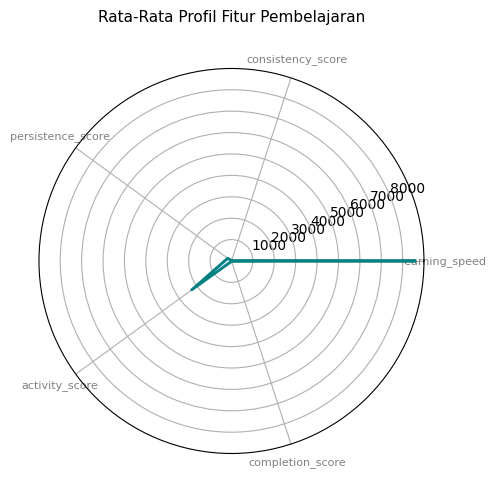

In [ ]:
# Statistik Deskriptif
print("Statistik Deskriptif Fitur Pembelajaran:\n")
display(learning_data.describe())

print("\n--------------------------------------------------------\n")

# Korelasi antar fitur
print("Korelasi antar Fitur:\n")
corr = learning_data[['learning_speed', 'consistency_score', 'persistence_score', 'activity_score', 'completion_score']].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.title('Heatmap Korelasi antar Fitur')
plt.show()

print("\n")

# Distribusi tiap fitur
features = ['learning_speed', 'consistency_score', 'persistence_score', 'activity_score', 'completion_score']
for feat in features:
    plt.figure(figsize=(6,3))
    sns.histplot(learning_data[feat], kde=True, color='steelblue')
    plt.title(f'Distribusi {feat}')
    plt.xlabel(feat)
    plt.ylabel("Frekuensi")
    plt.tight_layout()
    plt.show()

    print("\n")

# Pairplot antar fitur
print("Hubungan Antar Fitur (Pairplot):\n")
sns.pairplot(learning_data[['learning_speed', 'consistency_score', 'persistence_score', 'activity_score', 'completion_score']],
             diag_kind='kde', plot_kws={'alpha':0.6})
plt.show()
print("\n")

print("Visualisasi Profil Rata-Rata 5 Fitur (Radar Chart):\n")

mean_values = learning_data[features].mean().values
features_labels = np.array(features)

values = np.concatenate((mean_values, [mean_values[0]]))
angles = np.linspace(0, 2 * np.pi, len(features_labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(5,5))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], features_labels, color='grey', size=8)
ax.plot(angles, values, linewidth=2, linestyle='solid', color='teal')
ax.fill(angles, values, 'skyblue', alpha=0.4)
plt.title('Rata-Rata Profil Fitur Pembelajaran', size=11, y=1.1)
plt.show()

print("\n")

### Interpretasi Awal
- **Learning speed**
Menggambarkan seberapa cepat pengguna menyelesaikan suatu aktivitas pembelajaran. Nilai tinggi menunjukkan pengguna mampu belajar dengan cepat, sementara nilai rendah bisa berarti pengguna butuh waktu lebih lama untuk memahami materi.
- **Consistency score**
Mengukur kestabilan hasil ujian pengguna. Nilai standar deviasi yang kecil berarti pengguna memiliki performa yang stabil, sedangkan nilai besar menunjukkan fluktuasi performa belajar antar ujian.
- **Persistence score** Menunjukkan tingkat ketekunan pengguna dalam mengikuti ujian. Semakin tinggi nilainya, semakin sering pengguna berusaha mengulang ujian yang diambil terdapat indikasi bahwa pengguna gigih untuk mencapai hasil yang lebih baik.
- **Activity Score**
Mewakili seberapa aktif pengguna dalam membuka atau mempelajari tutorial yang tersedia. Semakin tinggi nilainya, semakin sering pengguna melakukan aktivitas belajar, baik itu membaca, membuka, atau menonton tutorial.
- **Completion Score**
Mengukur tingkat penyelesaian journey atau modul pembelajaran oleh pengguna. Nilai tinggi menunjukkan bahwa pengguna lebih konsisten menyelesaikan journey yang diikuti.

### Insight Awal dari Visualisasi
- Hasil heatmap korelasi memperlihatkan adanya hubungan menarik antara beberapa fitur:
  - Activity score dan completion score biasanya memiliki korelasi positif, artinya pengguna yang aktif cenderung juga menyelesaikan lebih banyak journey.
  - Persistence score dapat memiliki korelasi negatif terhadap learning speed, menunjukkan bahwa pengguna yang butuh banyak percobaan biasanya belajar lebih lambat.
- Distribusi fitur memperlihatkan bahwa sebagian besar pengguna memiliki learning speed rendah, activity menengah, namun variasi cukup besar pada persistence dan completion.
- Dari pairplot, terlihat beberapa pengguna memiliki pola unik, misalnya aktif tetapi kurang konsisten, atau cepat belajar namun jarang menyelesaikan journey.
- Radar chart memberikan gambaran rata-rata lima aspek utama pembelajaran pengguna, di mana titik terendah dapat menjadi fokus pengembangan sistem rekomendasi atau umpan balik personal.

# **Simpulan Sementara**

### Kesimpulan

EDA ini berhasil membentuk dan memvalidasi lima fitur utama hasil rekayasa (feature engineering) yang merepresentasikan perilaku belajar pengguna dari berbagai sisi seperti kecepatan, ketekunan, kestabilan, aktivitas, dan penyelesaian.
Kelima fitur ini layak digunakan sebagai dasar untuk model Machine Learning lanjutan, seperti:
- Clustering (K-Means) untuk mengelompokkan tipe pengguna berdasarkan pola belajarnya.
- Feedback AI untuk memberikan saran personal berbasis nilai skor setiap fitur.
- Monitoring dashboard untuk menampilkan perkembangan mingguan pengguna lewat grafik (line chart dan radar).

Analisis ini menunjukkan bahwa data pembelajaran pengguna cukup kaya dan dapat dikembangkan lebih lanjut menjadi sistem rekomendasi dan evaluasi performa belajar yang lebih adaptif.